<center><h1>RAPORT<h1></center><br>

<center><h2>W ramach pracy zaliczeniowej przedmiotu Języki programowania Python i R<h2></center><br>
    <center><h2>Modelowanie predykcji przeżycia katastrofy Titanica w ramach Kaggle:<h2></center> 
        <center><h2>Titanic: Machine Learning from Disaster<h2></center>
    
   

    
### Grzegorz Kuprewicz
### Inżynieria Danych - Data Science 2019/2020<br><br><br>
<center><h3>Gdańsk 2020<h3></center>

# 1. Wstęp

Celem pracy było sprostaniu ogólnodostępnemu wyzwaniu zamieszczonym na portalu Kaggle. Temat wyzwania dotyczy problemu klasyfikacji binarnej czy dany pasażer przeżył katastrofę statku Titanic w 1912 roku. 

Zbiorem treningowym wraz z ze zmienną celu był zbiór zawierający rekordy dla 819 pasażerów wraz z danymi zawartymi w 12 kolumnach

Słowniczek zmiennych:

| Zmienna	| Definicja                             	| Klucz                                                                                                                                                         	|
|----------	|------------------------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Survived 	| Czy dany pasażer przeżył                 	| 0 = Nie, 1 = Tak                                                                                                                                              	|
| Pclass   	| Klasa biletu                             	| 1 = 1wsza, 2 = 2ga, 3 = 3cia                                                                                                                                  	|
| Sex      	| Płeć                                     	|                                                                                                                                                               	|
| Name     	| Imię i nazwisko pasażera                 	|                                                                                                                                                               	|
| Age      	| Wiek w latach                            	| ułamek gdy mniejszy niż 1 rok, w formacie xx.5 gdy<br>wiek był estymowany                                                                                     	|
| SibSp    	| liczba rodzeństwa/małżonków na pokładzie 	| Sibling(rodzeństwo) = brat, siostra, brat przyrodni, siostra <br>przyrodnia<br>Spouse (małżonkowie) = mąż, żona <br>(kochanki i narzeczone nie były uznawane) 	|
| Parch    	| Liczba rodziców/dzieci na pokładzie      	| Parent (Rodzic) = mama, tata<br><br>Dziecko = córka, syn, przybrana córka, przybrany syn<br><br>Niektóre dzieci podróżowały tylko z nianią - wtedy Parch = 0  	|
| Ticket   	| Numer biletu                             	|                                                                                                                                                               	|
| Fare     	| Koszt biletu                             	|                                                                                                                                                               	|
| Cabin    	| Numer kabiny                             	|                                                                                                                                                               	|
| Embarked 	| Port zaokrętowania                       	| C = Cherbourg, Q = Queenstown, S = Southampton                                                                                                                	|

## Importowanie modułów

In [1]:
# Doinstalowanie brakującego modułu xgboost
!pip install xgboost

In [2]:
# Wczytanie niezbędnych modułów
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Wczytywanie modułów ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV as gridcv
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler

# Stworzenie instancji dla obiektu MinMaxScaler
minmax = MinMaxScaler()

sns.set() # domyślne ustawienia Matplotlib podczytano jako ustawnia Seaborn
pd.set_option('display.max_columns', None) # Zwiększenie liczby widocznych kolumn

# 2. Wczytanie i rozpoznanie danych

In [3]:
# Wczytanie danych z pliku csv do ramki danych
df_titanic = pd.read_csv(r"Dane\train.csv")

In [4]:
# Podgląd 5 wierszy z ramki danych
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Podstawowe informacje o zbiorze, typach zmiennych i ilości niepustych pól
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Zbiór zawiera informacje o 819 pasażerach natomiast zmienne "Age" oraz "Cabin" wykazują zauważalne braki w danych. <br> Zbiór zawiara zarówno wartości liczbowe - ciągłe, wartości które można uznać za kategoryczna jak również tekst.

#### Sprawdzenie poprawności klasyfikacji płci

W celu weryfikacji jakości danych zdecydowano się na sprawdzenie poprawności klasyfikacji płci pasażera. <br>Do tego celu wykorzystano tytuł znajdujący się w zmiennej "Name" każdego z pasażerów. 

In [6]:
# Wzór Regex do wyszukania kobiet
pattern = "Miss\.|Mrs\."

# Sprawdzenie czy w zmiennej "Name" występuje wzorzec. Zmapowanie płci "female" w przypadku wartości True. 
retrived_gender = df_titanic["Name"].str.contains(pattern, regex=True).map({True: "female", False: "male"})

# Zestawienie płci zawartej w oryginalnym zbiorze z płcią wywnioskowaną z pola "Name" - poszukiwanie niezgodności
incorrect_gender = df_titanic.Sex != retrived_gender

# Wyfiltrowanie problematycznych rekordów
df_titanic.loc[incorrect_gender]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S


Analiza wpisów niezawierających tytułów Miss. lub Mrs. wskazuje, że odpowiadają one również kobietom.  
Płeć została przypisana prawidłowo w całym zbiorze

Z uwagi na małą przydatność zmiennej "Name" zdecydowano się na wyodrębnienie z niej tytułu danego pasażera i zapisanie go w zmiennej "Title" do potencjalnego późniejszego wykorzystania w modelu. 

In [7]:
# Wyodbrębnienie tytułów za pomocą regexa wyszukującego wyrazy zakończone kropką
df_titanic["Title"] = df_titanic["Name"].str.extract("(\w*\.)")

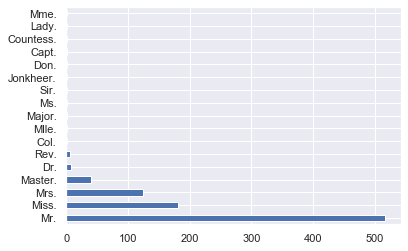

In [8]:
# Sprawdzenie liczności poszczególnych tytułow
df_titanic["Title"].value_counts().plot.barh()

Najczęściej występującymi tytułami są te najpowszechniejsze t.j. Mr. i Master. dla mężczyzn oraz Miss. i Mrs. dla kobiet. 

#### Sprawdzenie wartości zmiennej Age  
Sprawdzono liczbę pustych pól.  
Zgodnie z informacjami zawartymi w słowniczku, w przypadku gdy wiek pasażera był mniejszy niż 1 to wiek przestawiono jako ułamek.  
W przypadku gdy wiek był estymowany, wartość zawiera dodatkowo cyfrę 5 jako pierwszą cyfrę części dziesiętnej.

In [9]:
# Wzorzec do wyszukania oszacowanej wartości wieku 
pattern = "\d.5"

# Wyszukanie wzorca w wartości wieku potraktowanej jako ciąg znaków
estimated_age = df_titanic.Age.astype(str).str.contains(pattern, regex=True)
estimated_age.value_counts()

False    873
True      18
Name: Age, dtype: int64

Dla 18 pasażerów podany wiek jest wartością oszacowaną. 

In [10]:
# Sprawdzenie ilości wartości wieku mniejszego niż 1

df_titanic.Age[df_titanic.Age < 1].value_counts()

0.75    2
0.83    2
0.67    1
0.42    1
0.92    1
Name: Age, dtype: int64

Zdecydowano się przekształcić wartości wieku do liczb całkowitych:
- wiek poniżej 1 roku - przyjęto wiek równy 1
- wiek estymowany - zaokrąglono w górę do liczby całkowitej

#### Uzupełnienie pustych pól dla zmiennej Age

In [11]:
# Sprawdzenie liczby brakujących wartości
age_is_na = df_titanic["Age"].isna().sum()
age_is_na

177

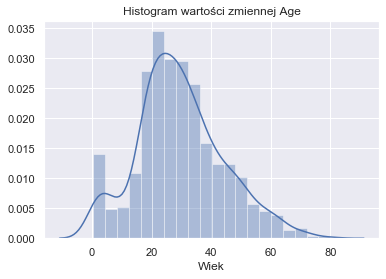

In [12]:
# Wygenerowanie histogramu wartośći dla zmiennej "Age"
age_title = df_titanic[["Age", "Title"]].dropna()
sns.distplot(age_title["Age"])
plt.title("Histogram wartości zmiennej Age")
plt.xlabel("Wiek")
plt.show()

Z uwagi na sporą liczbę brakujących danych o wieku pasażerów zdecydowano się na wylosowanie wartości wieku dla wygenerowanych wcześniej wartości wieku z wykorzystaniem rozkłądu normalnego bazującego na średniej oraz odchyleniu standardowym wyliczonym na bazie znanych wartości. 

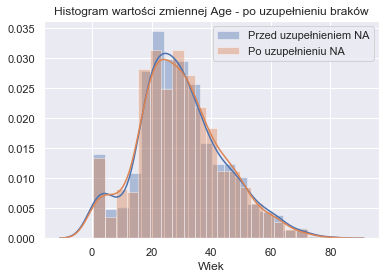

In [13]:
age = df_titanic["Age"].dropna()

# Zastąpienie brakujących wartości wartościami losowymi z rozkładem normalnym
mean = np.mean(age)
std = np.std(age)

# Wygenerowanie 5000 wartości wieku z rozkładem normalnym
generated_age = abs(np.random.normal(mean, std, 5000).round())

# Wylosowanie brakujących wartości korzystając z wygenerowanego zbioru
generated_age = np.random.choice(generated_age, age_is_na)

df_titanic.loc[df_titanic["Age"].isna(), "Age"] = generated_age

sns.distplot(age)
sns.distplot(df_titanic["Age"])
plt.title("Histogram wartości zmiennej Age - po uzupełnieniu braków")
plt.xlabel("Wiek")
plt.legend(["Przed uzupełnieniem NA", "Po uzupełnieniu NA"])
plt.show()

In [14]:
# Zaokrąglenie wieku poniżej 1 roku do 1 roku
df_titanic.loc[df_titanic.Age < 1, "Age"] = 1

# Zaokrąglenie wartości wieku oszacowanego do liczby całkowitej
df_titanic.loc[estimated_age, "Age"].apply(np.ceil)

# Ustawienie typu zmiennej "Age" jako int
df_titanic["Age"].astype(int)

0      22
1      38
2      26
3      35
4      35
       ..
886    27
887    19
888    18
889    26
890    32
Name: Age, Length: 891, dtype: int32

Wszysktkie pola dla zmiennej "Age" zawierają już wartości. 

#### Sprawdzenie nadal występujących braków w danych

In [15]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


Występujące nadal braki to pola dla zmiennych "Cabin" oraz "Embarked"

#### Zmienna "Cabin"

In [16]:
# Wyświetlenie 10 pierwszych niepustych wartości dla zmiennej "Cabin"
print(df_titanic["Cabin"].dropna().head(10))

# Wyświetlenie udziału pustych pól dla zmiennej "Cabin"
na_cabin_ratio = df_titanic["Cabin"].isna().sum() / df_titanic.shape[0]
print("\n\nUdział pustych pól dla zmiennej 'Cabin' wynosi {:.2f} procent.".format(na_cabin_ratio * 100))

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object


Udział pustych pól dla zmiennej 'Cabin' wynosi 77.10 procent.


Litery przy oznaczeniu kabiny wskazują na pokład na którym znajduje się dana kabina. Wystąpienie wpisu z więcej niż jedną kabiną oznacza, że dany pasażer wykupił kilka przyległych kabin, które połączył ze sobą. <br>Nawet po uzyskaniu o informacji o pokładzie na którym zaokrętowany był dany pasażer, braków w polu było tak dużo (77 %), że zdecydowano się odrzucić zmienną "Cabin". 

In [17]:
# Usunięcie zmiennej "Cabin" z ramki danych
df_titanic.drop("Cabin", axis=1, inplace=True)

#### Zmienna "Embarked"

W przypadku zmiennej "Embarked" brakujące wartości wystąpiły wyłącznie dla 2 pól. Zdecydowano się na usunięcie owych rekordów. 

In [18]:
# Indeks wierszy dla których zmienna "Embarked" nie zawiera wartości
ix = df_titanic[df_titanic["Embarked"].isna()].index

# Usunięcie wskazanych wierszy
df_titanic.drop(ix, axis=0, inplace=True)

In [19]:
# Sprawdzenie informacji o zbiorze - brak pustych pól
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
Title          889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


Zbiór poddany dalszej analizie nie zawiera już pustych pól - finalnie analizowane jest 889 rekordów z początkowych 891. 

# 3. EDA

Indeksem ramki danych ustanowiono zmienną "PassengerId"

In [20]:
# Wykorzystanie "PassengerId" jako indeksu zbioru
df_titanic.set_index("PassengerId", inplace=True)

In [21]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 11 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
Title       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


#### Analiza typów zmiennych 

In [22]:
print("Liczba unikalnych rekordów zmiennej 'Ticket':  {} \n\n".format(df_titanic["Ticket"].unique().size))
df_titanic.head(20)

Liczba unikalnych rekordów zmiennej 'Ticket':  680 




,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr.
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs.
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs.
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr.
6,0,3,"Moran, Mr. James",male,37.0,0,0,330877,8.4583,Q,Mr.
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Mr.
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Master.
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Mrs.


- Zmienne "Survived", "Pclass", "Sex", "Embarked", "Title" stanowią zmienne kategoryczne
- Zmienna ticket zawiera 680 unikalnych rekordów - zdecydowano się na jej usunięcie

In [23]:
# Zmiana typów zmiennych
df_titanic = df_titanic.astype({"Survived": "category", "Pclass": "category", 
                   "Sex": "category", "Embarked": "category",
                  "Title": "category"})

# Usunięcie zmiennej Ticket
df_titanic.drop("Ticket", axis=1, inplace=True)

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 10 columns):
Survived    889 non-null category
Pclass      889 non-null category
Name        889 non-null object
Sex         889 non-null category
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null category
Title       889 non-null category
dtypes: category(5), float64(2), int64(2), object(1)
memory usage: 47.2+ KB


In [24]:
# Wyświetlenie podstawowej statystyki dla zmiennych liczbowych
df_titanic.describe()

,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000
mean,29.584927,0.524184,0.382452,32.096681
std,14.241693,1.103705,0.806761,49.697504
min,1.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Text(0, 0.5, 'Liczba rodzeństwa / małżonków na pokładzie')

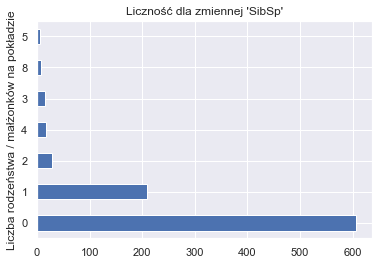

In [25]:
# Przygotowanie wykresu liczności wystąpień dla poszczególnych wartości zmiennej SibSp 
# (liczba rodzeństwa i małżonków na pokładzie)
df_titanic["SibSp"].value_counts().plot.barh()
plt.title("Liczność dla zmiennej 'SibSp'")
plt.ylabel("Liczba rodzeństwa / małżonków na pokładzie")

Zdecydowana większość pasażerów podróżowała bez rodzeństwa lub żony/męża. 

Text(0, 0.5, 'Liczba rodziców / dzieci na pokładzie')

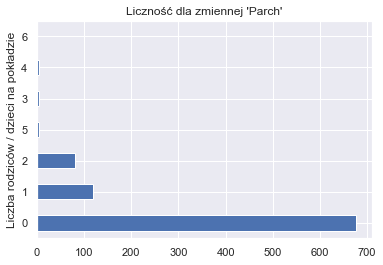

In [26]:
# Przygotowanie wykresu liczności wystąpień dla poszczególnych wartości zmiennej Parch
# (liczba rodziców i dzieci na pokładzie)
df_titanic["Parch"].value_counts().plot.barh()
plt.title("Liczność dla zmiennej 'Parch'")
plt.ylabel("Liczba rodziców / dzieci na pokładzie")

Zdecydowana większość pasażerów podróżowała bez dzieci/rodzica.<br> Zdecydowano się zestawić zmienne "SibSp" oraz "Parch" w postaci tabeli przestawnej by zweryfikować czy występują dominuące typy pasażerów.

In [27]:
# Zestawienie tablicy przestawnej dla zmiennych SibSp i Parch
pd.pivot_table(df_titanic[["SibSp", "Parch"]], index="SibSp", columns="Parch", aggfunc=len)

Parch,0,1,2,3,4,5,6
SibSp,,,,,,,
0,535.0,38.0,29.0,1.0,1.0,2.0,NaN
1,123.0,57.0,19.0,3.0,3.0,3.0,1.0
2,16.0,7.0,4.0,1.0,NaN,NaN,NaN
3,2.0,7.0,7.0,NaN,NaN,NaN,NaN
4,NaN,9.0,9.0,NaN,NaN,NaN,NaN
5,NaN,NaN,5.0,NaN,NaN,NaN,NaN
8,NaN,NaN,7.0,NaN,NaN,NaN,NaN


Aż 535 pasażerów podróżowało zupełnie samotnie. Zdecydowano się na stworzenie nowej zmiennej "Solo" w przypadku gdy dany pasażer podróżował samotnie - przyjmuje ona wartość 1

In [28]:
# Stworzenie nowej zmiennej Solo
df_titanic["Solo"] = ((df_titanic["SibSp"] == 0) & (df_titanic["Parch"] == 0)).astype("category")

In [29]:
df_titanic.Solo.value_counts()

True     535
False    354
Name: Solo, dtype: int64

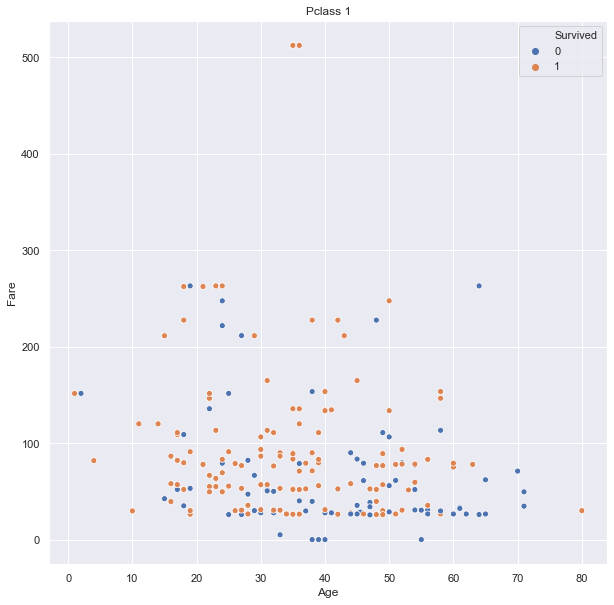

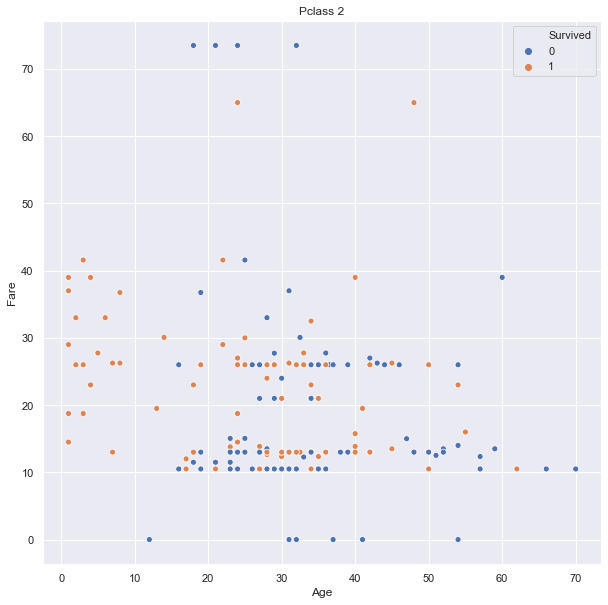

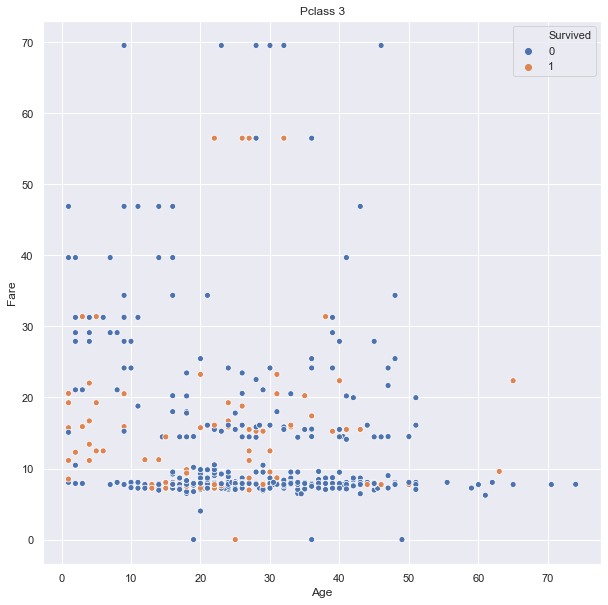

In [30]:
for pclass in range(1,4):
    plt.figure(figsize=(10,10))
    sns.scatterplot(data = df_titanic[df_titanic["Pclass"]==pclass], hue="Survived", x="Age", y="Fare")
    plt.title("Pclass {}".format(pclass))

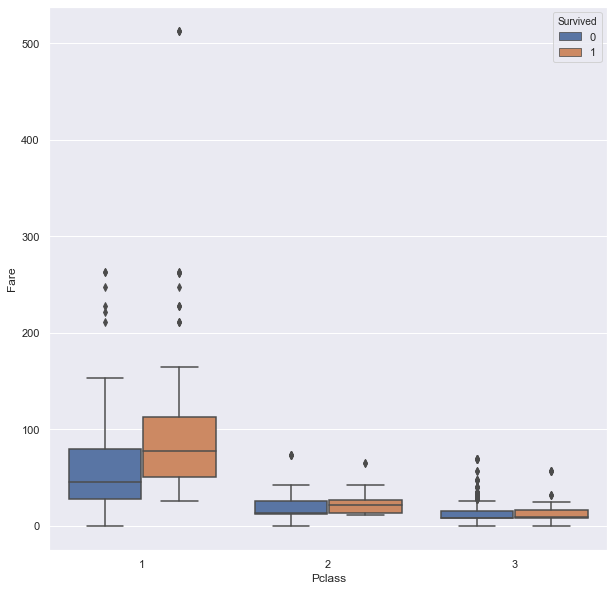

In [31]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_titanic,x="Pclass", y="Fare", hue="Survived", orient="v")

Wykresy rozrzutu przedstawiają osobno pasażerów każdej z klas biletów pod kątem wieku i ceny biletu. Kolorystycznie przedstawiono czy dany pasażer przeżył czy też zginął w katastrofie. W przypadku klasy 1 można zauważyć dwie wartości zdecydowanie odstające od reszty rezultatów pod kątem ceny biletu. Potwierdza to również boxplot. Zdecydowano się na usnięcie tych rekordów. 

In [32]:
# Usunięcie wartości odstających - Cena biletu powyżej 300 dolarów
df_titanic.drop(df_titanic[df_titanic["Fare"] > 300].index, axis=0, inplace=True)

In [33]:
# Sprawdzenie pasażerów płynących za darmo
df_titanic[df_titanic["Fare"] == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Solo
PassengerId,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,0.0,S,Mr.,True
264,0,1,"Harrison, Mr. William",male,40.0,0,0,0.0,S,Mr.,True
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,0.0,S,Mr.,True
278,0,2,"Parkes, Mr. Francis ""Frank""",male,54.0,0,0,0.0,S,Mr.,True
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,0.0,S,Mr.,True
414,0,2,"Cunningham, Mr. Alfred Fleming",male,41.0,0,0,0.0,S,Mr.,True
467,0,2,"Campbell, Mr. William",male,12.0,0,0,0.0,S,Mr.,True
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,31.0,0,0,0.0,S,Mr.,True
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,0.0,S,Mr.,True


Pasażerowie podróżujący za darmo mają podobne cechy - port, samotna podróż. Zdecydowano utworzyć się dodatkową zmienną "Crew", domniejmując że pasażerowie podróżujący za darmo należeli do załogi. 

In [34]:
# Stworzenie nowej zmiennej - przynależność do załogi gdy cena biletu = 0
df_titanic["Crew"] = df_titanic["Fare"] == 0

Text(0.5, 1.0, 'Przeżywalność ze względu na klasę oraz wiek')

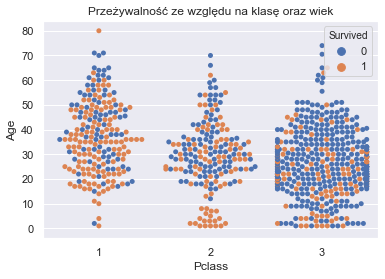

In [35]:
# Wykres roju z podziałem na klasy pasażerów oraz czy przeżyli katastrofę
sns.swarmplot(data = df_titanic, x="Pclass", y="Age", hue="Survived")
plt.title("Przeżywalność ze względu na klasę oraz wiek")

Text(0.5, 1.0, 'Przeżywalność ze względu na fakt samotnej podróży oraz wiek')

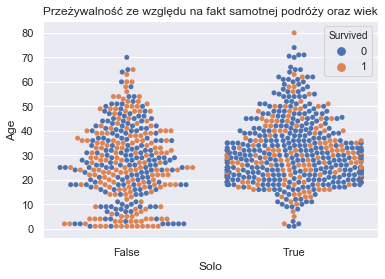

In [36]:
sns.swarmplot(data=df_titanic, x="Solo", y="Age", hue="Survived")
plt.title("Przeżywalność ze względu na fakt samotnej podróży oraz wiek")

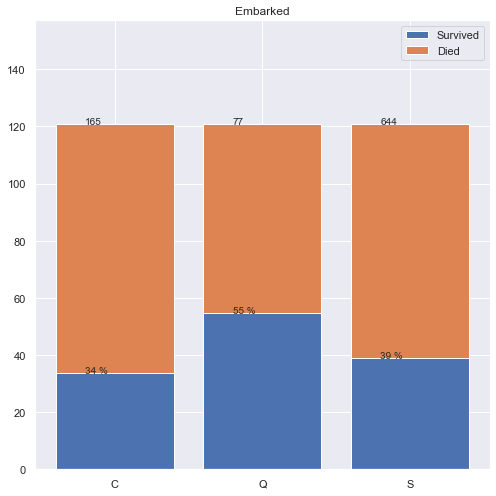

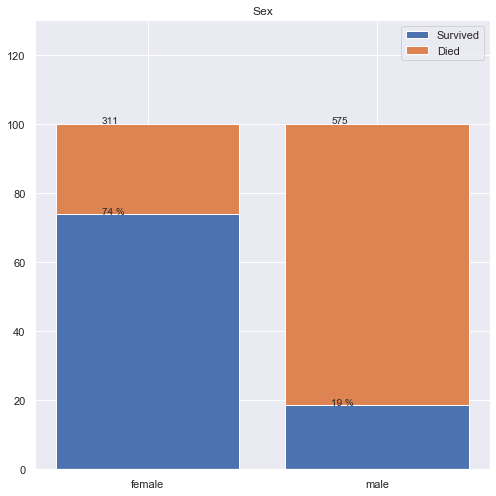

In [37]:
for col in ["Embarked", "Sex"]:
    plt.figure(figsize=(7, 7))
    labels_list = df_titanic[col].cat.categories
    survived_yes = df_titanic.loc[df_titanic["Survived"] == 1][col].value_counts()
    survived_no = df_titanic.loc[df_titanic["Survived"] == 0][col].value_counts()
    survived = survived_yes + survived_no
    bar_yes = plt.bar(x=labels_list, height=survived_yes * 100 / survived)
    bar_no = plt.bar(x=labels_list, height=survived_no * 100 / survived, bottom=survived_yes * 100 / survived)
    plt.legend(["Survived", "Died"])
    plt.title(str(col))

    for bar in bar_yes:
        width, height = bar.get_width(), bar.get_height()
        x, y = bar.get_xy()
        plt.annotate('{0:.0f} %'.format(height), (x + width / 4, y + height + 0.01))

    for i, bar in enumerate(bar_no):
        width, height = bar.get_width(), bar.get_height()
        x, y = bar.get_xy()
        plt.annotate('{0:d}'.format(survived[i]), (x + width / 4, y + height + 0.1))

    plt.margins(y=0.3, tight=True)
    plt.tight_layout()
    plt.show()

- Można zauważyć dużo większą przeżywalność wśród kobiet.
- Podróżowanie solo (w kontekście więzi rodzinnych z osobami na pokładzie) też wydaje się wpływać na szansę na przeżycie.
- Widać zależność między podróżowaniem w poszczególnych klasach - im wyższa klasa tym szanse na ocalenie wydają się większe. 
- Port zaokrętowania wydaje się nie mieć większego wpływu na szansę na przeżycie, jedynie pasażerowie zaokrętowani w Queenstown wydają się mieć potencjalnie większą szansę na przeżycie.

# 4. Feature engineering

In [38]:
# Stworzenie deep copy ramki danych
df = df_titanic.copy()
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Solo,Crew
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr.,False,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs.,False,False
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss.,True,False
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs.,False,False
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr.,True,False


Zdecydowano się na kilka operacji na zmiennych:
- Zamiana zmiennej "Sex" na binarną "Female - gdzie 1 oznacza kobietę, 0 - mężczyznę
- Binaryzacja zmiennych "Crew", "Solo" - 1 - tak, 0 - nie
- Wyodrębnienie tytułów pasażerów występujących najczęściej i zaklasyfikowanie pozostałych jako Others. Następnie zdecydowano się na binaryzację z wykorzystaniem metody One-Hot Encoding pomijając zmienną "Title_Other"
- Zmiana zmiennej "Embarked" na zmienną binarną "Embarked_Q" - 1 gdy pasażer okrętował się w Queenstown, 0 - w innym porcie
- Stworzenie zmiennej będącej kwadratem wartości wieku
- Usunięcie zmiennych "Name", "Title"

In [39]:
# Zmiana zmiennej "Sex" na zmienną binarną "Female"
df.rename(columns={"Sex": "Female"}, inplace=True)
df["Female"] = df["Female"].replace(to_replace={"female": 1, "male": 0})

In [40]:
# Binaryzacja zmiennych "Crew" oraz "Solo"
for col in ["Crew", "Solo"]:
    df[col] = pd.factorize(df[col])[0]

In [41]:
# Wyodrębnienie kategorii "Other" dla zmiennej "Title" w przypadku gdy tytuł nie należy do listy 
# "Mrs.", "Miss.", "Mr.", "Master."

# Zamiana typu zmiennej na object
df["Title"] = df["Title"].astype("object")

# Ustawienie nowej wartości dla tytułów nie należących do listy
df.loc[~df["Title"].isin(["Mrs.", "Miss.", "Mr.", "Master."]), "Title"] = "Other"

# Powrót do typu zmiennej będącej kategorią
df["Title"] = df["Title"].astype("category")

# Zmiana zmiennej "Title" na zmienne binarne
dummy_title = pd.get_dummies(df["Title"], prefix="Title")

# Odrzucenie zmiennej "Title_Other" - One-hot Encoding
dummy_title.drop("Title_Other", axis=1, inplace=True)
# Dodanie nowych kolumn do istniejącego zbioru
df = pd.concat((df, dummy_title), axis=1)

In [42]:
# Zmiana zmiennej "Embarked" na zmienną "Embarked_Q" wskazującą czy dany pasażer okrętowałe się w Queenstown
df.rename(columns={"Embarked": "Embarked_Q"}, inplace=True)
df["Embarked_Q"] = df["Embarked_Q"].replace(to_replace={"Q": 1, "S": 0, "C": 0})

In [43]:
# Dodanie zmiennej będącej kwadratem wieku
df["Age_2"] = df["Age"] ** 2

In [44]:
# Odrzucenie zmiennych "Name" oraz "Title"
df.drop(["Title", "Name"], axis=1, inplace=True)

# 5. Modelowanie

Zdecydowano się na wykorzystanie trzech rodzajów modelów:
- regresji logistycznej poprzedzonej normalizacją według metody MinMax
- metody lasów losowych - Random Forest
- metody xGBoost

Dodatkowo w celu kalibracji hiperparametrów zdecydowano się na wykorzystanie metody GridSearch dla każdego z estymatorów by znaleźć najlepszy rezultat dla metryki AUC (area under ROC curve) w procesie Cross Validation dla 5 prób (foldów). 

Ponadto sprawdzono podejście z jednym modelem dla całego zbioru oraz uczenie oparte na osobnych modelach dla zbiorów podzielonych pod kątem płci. 

Najlepsze z modeli dla danego typu estymatora poddano finalnej walidacji krzyżowaej z wykorzystaniem 5 prób i metryk:
- F1
- Accuracy
- Precision

Zbiór zmiennych i zbiór zmiennej objaśnianej

In [45]:
X = df.drop(["Survived"], axis=1)
y = df["Survived"]

Zbiór zmiennych i zbiór zmiennych objaśniających z podziałem na płeć

In [46]:
X_m = df[df["Female"] == 0].drop("Survived", axis=1)
y_m = df.loc[df["Female"] == 0, "Survived"]

X_f = df[df["Female"] == 1].drop("Survived", axis=1)
y_f = df.loc[df["Female"] == 1, "Survived"]

#### Regresja liniowa z normalizacją

W procesie Grid Search poszukiwano optymalnego zestawu parametrów dla:
- wartości C - odpowiadajacej regularyzacji (odwrotność parametru lambda) 
- metodzie regularyzacji (penalty) - według metody l1 (Lasso) i l2 (Ridge)

In [47]:
# Stworzenie instancji obiektu Logistic Regression
lr = LogisticRegression(solver="liblinear")
# Zadeklarowanie obiektu typu Pipeline - wykonanie kilku następujących po sobie operacji

# Normalizacja -> Regresja logistyczna
norm_lr = Pipeline(steps=[("normalisation", minmax), ("LR", lr)])

# Zadeklarowanie siatki parametrów do kalibracji hiperparametrów
params = {"LR__C": [0.01, 0.1, 1, 10, 100],
         "LR__penalty": ["l1", "l2"]}

# Stworzenie instancji obiektu GridSearch ze wskazaniem estymatora, 
# siatki parametrów, metryki, liczby foldów w CrossValidation, wykorzystania wielowątkowości
grid_lr = gridcv(norm_lr, params, scoring="roc_auc", cv=5, n_jobs=-1)

grid_lr.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalisation',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('LR',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           

In [48]:
lr = LogisticRegression(solver="liblinear")
norm_lr = Pipeline(steps=[("normalisation", minmax), ("LR", lr)])
params = {"LR__C": [0.01, 0.1, 1, 10, 100],
         "LR__penalty": ["l1", "l2"]}

grid_lr_m = gridcv(norm_lr, params, scoring="roc_auc", cv=5, n_jobs=-1)
grid_lr_m.fit(X_m, y_m)

grid_lr_f = gridcv(norm_lr, params, scoring="roc_auc", cv=5, n_jobs=-1)
grid_lr_f.fit(X_f, y_f)

C:\Users\grzegorz.kuprewicz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\grzegorz.kuprewicz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('normalisation',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('LR',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           

In [49]:
# Wyświetlenie rezultatów w formie ramki danych
pd.DataFrame(grid_lr.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
7,0.019679,"{'LR__C': 10, 'LR__penalty': 'l2'}",0.865678,1
5,0.034707,"{'LR__C': 1, 'LR__penalty': 'l2'}",0.865336,2
4,0.020744,"{'LR__C': 1, 'LR__penalty': 'l1'}",0.865120,3
6,0.030858,"{'LR__C': 10, 'LR__penalty': 'l1'}",0.863912,4
9,0.017367,"{'LR__C': 100, 'LR__penalty': 'l2'}",0.862170,5
8,0.076292,"{'LR__C': 100, 'LR__penalty': 'l1'}",0.861467,6
3,0.028489,"{'LR__C': 0.1, 'LR__penalty': 'l2'}",0.856498,7
2,0.026596,"{'LR__C': 0.1, 'LR__penalty': 'l1'}",0.847303,8
1,0.020608,"{'LR__C': 0.01, 'LR__penalty': 'l2'}",0.844509,9
0,0.009896,"{'LR__C': 0.01, 'LR__penalty': 'l1'}",0.779756,10


In [50]:
pd.DataFrame(grid_lr_m.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
5,0.008577,"{'LR__C': 1, 'LR__penalty': 'l2'}",0.707332,1
4,0.008776,"{'LR__C': 1, 'LR__penalty': 'l1'}",0.697109,2
3,0.008776,"{'LR__C': 0.1, 'LR__penalty': 'l2'}",0.694658,3
7,0.009179,"{'LR__C': 10, 'LR__penalty': 'l2'}",0.692733,4
9,0.007380,"{'LR__C': 100, 'LR__penalty': 'l2'}",0.682195,5
6,0.015758,"{'LR__C': 10, 'LR__penalty': 'l1'}",0.681369,6
8,0.016553,"{'LR__C': 100, 'LR__penalty': 'l1'}",0.681219,7
1,0.007826,"{'LR__C': 0.01, 'LR__penalty': 'l2'}",0.679679,8
2,0.010173,"{'LR__C': 0.1, 'LR__penalty': 'l1'}",0.678242,9
0,0.008378,"{'LR__C': 0.01, 'LR__penalty': 'l1'}",0.596626,10


In [51]:
pd.DataFrame(grid_lr_f.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
8,0.018350,"{'LR__C': 100, 'LR__penalty': 'l1'}",0.845379,1
9,0.005385,"{'LR__C': 100, 'LR__penalty': 'l2'}",0.844331,2
6,0.010571,"{'LR__C': 10, 'LR__penalty': 'l1'}",0.841116,3
7,0.004788,"{'LR__C': 10, 'LR__penalty': 'l2'}",0.840633,4
4,0.004588,"{'LR__C': 1, 'LR__penalty': 'l1'}",0.835468,5
5,0.005785,"{'LR__C': 1, 'LR__penalty': 'l2'}",0.834285,6
2,0.006184,"{'LR__C': 0.1, 'LR__penalty': 'l1'}",0.792574,7
3,0.004987,"{'LR__C': 0.1, 'LR__penalty': 'l2'}",0.784140,8
1,0.005389,"{'LR__C': 0.01, 'LR__penalty': 'l2'}",0.647955,9
0,0.006379,"{'LR__C': 0.01, 'LR__penalty': 'l1'}",0.500000,10


Można zauważyć, że rozbicie na dwa osobne modele dla każdej z płci wydaje się nie przynosić poprawy rezultatów. 
Bazując na metryce AUC najlepszym wydaje się wykorzystanie regularyzacji metodą Ridge oraz z parametrem C = 10. <br> Zestaw parametrów, dla których uzyskano najlepsze rezultaty zostanie użyty podczas dalszej procedury wyboru finalnego modelu.

#### Random Forest

W przypadku metody Random Forest założono wykorzystanie 400 drzew decyzyjnych. Jako hiperparametry sprawdzono:
- maksymalną liczbę zmiennych (max features) - wybrano brak ograniczenia, oraz pierwiastek z liczby zmiennych
- kryterium oceny podziału na gałęzie - Gini oraz entropia

In [52]:
# Stworzenie instancji obiektu RandomForestClassifier o 400 drzewach
rf = RandomForestClassifier(n_estimators=400)

# Sieć hiperparametrów
params = {"max_features": [None, "sqrt"],
         "criterion": ["gini", "entropy"]}

grid_rf = gridcv(rf, params, scoring="roc_auc", cv=5, n_jobs=-1)
grid_rf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=400, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [53]:
rf = RandomForestClassifier(n_estimators=400)

params = {"max_features": [None, "sqrt"],
         "criterion": ["gini", "entropy"]}

grid_rf_m = gridcv(rf, params, scoring="roc_auc", cv=5, n_jobs=-1)
grid_rf_m.fit(X_m, y_m)

grid_rf_f = gridcv(rf, params, scoring="roc_auc", cv=5, n_jobs=-1)
grid_rf_f.fit(X_f, y_f)

C:\Users\grzegorz.kuprewicz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=400, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [54]:
# Wyświetlenie rezultatów w formie ramki danych
pd.DataFrame(grid_rf.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
3,0.664415,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.872846,1
1,0.621785,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.870155,2
2,1.248543,"{'criterion': 'entropy', 'max_features': None}",0.867155,3
0,0.999324,"{'criterion': 'gini', 'max_features': None}",0.864702,4


In [55]:
pd.DataFrame(grid_rf_m.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
1,0.544610,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.733604,1
3,1.334588,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.727861,2
0,0.718002,"{'criterion': 'gini', 'max_features': None}",0.726601,3
2,1.143693,"{'criterion': 'entropy', 'max_features': None}",0.718697,4


In [56]:
pd.DataFrame(grid_rf_f.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
3,0.689693,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.821478,1
1,0.967746,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.813553,2
2,0.989829,"{'criterion': 'entropy', 'max_features': None}",0.805875,3
0,1.695311,"{'criterion': 'gini', 'max_features': None}",0.792926,4


Ponownie, jak w przypadku regresji logistycznej, rozbicie na dwa osobne modele nie przyniosło poprawy rezultatu dla metryki AUC. <br> Do dalszej procedury wyboru finalnego modelu wybrano model wykorzystujący kryterium "gini" oraz uwzględniający maksymalną liczbę zmiennych jako pierwiastek z liczby zmiennych.

#### XGboost

W przypadku metody wykorzystującej pakiet XGboost dla klasyfikacji zdecyodwano się na sprawdzenie hiperparametru:
- booster - wykorzystanie liniowego oraz opartego na drzewach decyzyjnych

In [57]:
X_m["Pclass"].unique()

[3, 1, 2]
Categories (3, int64): [3, 1, 2]

In [58]:
# Stworzenie instancji obiektu 
xgb_est = xgb.XGBClassifier()

# Sieć parametrów do przeprowadzenia GridSearch
params = {"booster": ["gblinear", "gbtree"]}

grid_xgb = gridcv(xgb_est, params, scoring="roc_auc", cv=5, n_jobs=-1)

# Z uwagi na występujący wyjątek zmieniono typ zmiennej "Pclass" na liczbę całkowitą.
X["Pclass"] = X["Pclass"].astype(int)


grid_xgb.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'booster': ['gblinear', 'gbtree']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', 

In [59]:
X_m["Pclass"] = X_m["Pclass"].astype(int)
X_f["Pclass"] = X_f["Pclass"].astype(int)

grid_xgb_f = gridcv(xgb_est, params, scoring="roc_auc", cv=5, n_jobs=-1)
grid_xgb_m = gridcv(xgb_est, params, scoring="roc_auc", cv=5, n_jobs=-1)

grid_xgb_f.fit(X_f, y_f)
grid_xgb_m.fit(X_m, y_m)

C:\Users\grzegorz.kuprewicz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\grzegorz.kuprewicz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'booster': ['gblinear', 'gbtree']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', 

In [60]:
# Rezultaty przedstwione w formie ramki danych 
pd.DataFrame(grid_xgb.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
1,0.171481,{'booster': 'gbtree'},0.868983,1
0,0.619143,{'booster': 'gblinear'},0.769178,2


In [61]:
# Rezultaty przedstwione w formie ramki danych 
pd.DataFrame(grid_xgb_f.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
1,0.099936,{'booster': 'gbtree'},0.808714,1
0,0.128256,{'booster': 'gblinear'},0.749437,2


In [62]:
# Rezultaty przedstwione w formie ramki danych 
pd.DataFrame(grid_xgb_m.cv_results_)[["mean_fit_time", "params", "mean_test_score", "rank_test_score"]].sort_values("rank_test_score")

,mean_fit_time,params,mean_test_score,rank_test_score
1,0.120939,{'booster': 'gbtree'},0.707446,1
0,0.138041,{'booster': 'gblinear'},0.617778,2


Ponownie podział na osobne modele dla poszczególnych płci nie przyniósł lepszego rezulatu niż zastosowanie jednego modelu.<br> Warto zwrócić uwagę, że lepszy okazał się model wykorzystujący booster oparty na drzewach decyzyjnych osiągając nieznacznie lepszy wynik niż RandomForest - przy czym czas nauki był znacząco niższy niż w przypadku Random Forest. 

### Wybór finalnego modelu

Do wyboru finalnego modelu posłużą najlepsze z modeli dla każdej z metod. Ich rezultaty zostaną zestawione dla następujących metryk:
- F1
- Accuracy
- Precision

<br>Na bazie analizy rezultatów wybrany zostanie finalny estymator służący do predykcji na zbiorze testowym. 

In [63]:
# Stworzenie listy modelu do testu poprzez pobranie najlpeszego estymatora dla odpowiednich Grid Search
model_to_test = [grid_lr.best_estimator_, grid_rf.best_estimator_, grid_xgb.best_estimator_]

# Stworzenie pustej ramki danych do gromadzenia wyników
df_scores = pd.DataFrame()

# Iteracja po każdym z estymatorów w celu scoringu
for model in model_to_test:
    # Pobranie nazwy estymatora 
    name = model.__class__.__name__
    # Dokonanie scoringu
    score = cross_validate(model, X, y, cv=5, scoring=["f1", "accuracy", "precision"])
    
    # Uśrednienie wyników 
    for key, value in score.items():
        score[key] = np.mean(value)
    
    # Stworzenie obiektu Series i nadanie nazwy danego estymatora
    score_as_series = pd.Series(score).rename(name)
    
    # Dodanie serii do ramki danych
    df_scores = df_scores.append(score_as_series)

# Wyświetlenie rezultatu
df_scores

,fit_time,score_time,test_accuracy,test_f1,test_precision
Pipeline,0.006582,0.010771,0.818344,0.750532,0.781658
RandomForestClassifier,0.446576,0.091446,0.822876,0.763870,0.772314
XGBClassifier,0.087212,0.007792,0.829599,0.756555,0.822708


Analiza rezultatów wskazuje, że najlepsze rezultaty dla wszystkich trzech metryk uzyskał estymator oparty na metodzie XGBoost. Model zbudowany na tym estymatorze zostanie wykorzystany finalnie do predykcji dla zbioru testowego. 

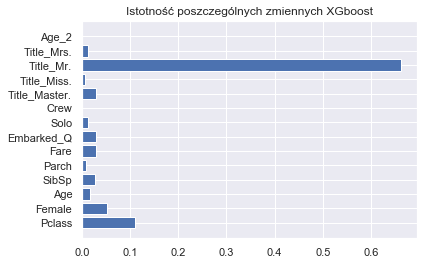

In [65]:
xgb_features_imp = grid_xgb.best_estimator_.feature_importances_
features = X.columns

plt.barh(features, xgb_features_imp)
plt.title("Istotność poszczególnych zmiennych XGboost")
plt.show()

Najbardziej istotną zmienną okazała się zmienna "Title_Mr.". Zmienna ta ma związek, że określa płeć, która, bazując na EDA miała znaczący wpływ na szansę przeżycia. Kolejną w kolejności istotności okazała się zmienna "Pclass" - co również wskazywało EDA. <br>Zmienne "Crew" oraz "Age_2" okazały się nieistotne.

In [66]:
final_model = grid_xgb.best_estimator_

In [67]:
def preapre_data_predict(df):
    
    """
    Funkcja odpowiada za przygotowanie zbioru testowego do postaci umożliwiającej predykcję 
    z wykorzystaniem finalnego modelu
    
    Parameters:
    df : DataFrame
        Obiekt wyjściowy zawierający zbiór testowy
        
    Return:
    X_test : DataFrame
        Obiekt stanowiący zbiór testowy przekształcony do postaci wykorzystywanej w modelu
    """
    
    # Wykorzystanie "PassengerId" jako indeksu zbioru
    df.set_index("PassengerId", inplace=True)

    # Wyrzucenie zmiennej Ticket
    df.drop(["Ticket", "Cabin"], axis=1, inplace=True)

    # Stworzenie zmiennej Solo dla osób podróżujących w pojedynkę
    df["Solo"] = ((df["SibSp"] == 0) & (df["Parch"] == 0)).astype("category")

    # Stworzenie zmiennej Crew dla osób podróżujących za darmo
    df["Crew"] = df["Fare"] == 0

    # Zmiana zmiennej "Sex" na zmienną binarną "Female"
    df.rename(columns={"Sex": "Female"}, inplace=True)
    df["Female"] = df["Female"].replace(to_replace={"female": 1, "male": 0})

    # Binaryzacja zmiennych "Crew" oraz "Solo"
    for col in ["Crew", "Solo"]:
        df[col] = pd.factorize(df[col])[0]
    
    # Uzyskanie zmiennej "Title" wykorzystując zmienną "Name"
    df["Title"] = df["Name"].str.extract("(\w*\.)")
    
    # Wyodrębnienie kategorii "Other" dla zmiennej "Title" w przypadku gdy tytuł nie należy do listy
    # "Mrs.", "Miss.", "Mr.", "Master."

    # Zamiana typu zmiennej na object
    df["Title"] = df["Title"].astype("object")

    # Ustawienie nowej wartości dla tytułów nie należących do listy
    df.loc[~df["Title"].isin(["Mrs.", "Miss.", "Mr.", "Master."]), "Title"] = "Other"

    # Powrót do typu zmiennej będącej kategorią
    df["Title"] = df["Title"].astype("category")

    # Zmiana zmiennej "Title" na zmienne binarne
    dummy_title = pd.get_dummies(df["Title"], prefix="Title")

    # Odrzucenie zmiennej "Title_Other" - One-hot Encoding
    dummy_title.drop("Title_Other", axis=1, inplace=True)
    # Dodanie nowych kolumn do istniejącego zbioru
    df = pd.concat((df, dummy_title), axis=1)

    
    # Zmiana zmiennej "Embarked" na zmienną "Embarked_Q" wskazującą czy dany pasażer okrętowałe się w Queenstown
    df.rename(columns={"Embarked": "Embarked_Q"}, inplace=True)
    df["Embarked_Q"] = df["Embarked_Q"].replace(to_replace={"Q": 1, "S": 0, "C": 0})

    # Dodanie zmiennej będącej kwadratem wieku
    df["Age_2"] = df["Age"] ** 2

    # Odrzucenie zmiennych "Name" oraz "Title"
    df.drop(["Title", "Name"], axis=1, inplace=True)
     
    # Zmiana typu danych dla zmiennej Pclass
    df["Pclass"] = df["Pclass"].astype(int)
    
    # Deep copy df do zmiennej X_test
    X_test = df.copy()

    return X_test

In [68]:
# Podczytanie danych testowych z CSV
df_test = pd.read_csv(r"Dane\test.csv")

# Podgląd zbioru przed przekształceniem
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [69]:
# Przygotowanie zbioru do predykcji
X_test = preapre_data_predict(df_test)

In [70]:
# Podgląd zbioru po przeskształceniu
X_test.head()

,Pclass,Female,Age,SibSp,Parch,Fare,Embarked_Q,Solo,Crew,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Age_2
PassengerId,,,,,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,1,0,0,0,0,1,0,1190.25
893,3,1,47.0,1,0,7.0000,0,1,0,0,0,0,1,2209.00
894,2,0,62.0,0,0,9.6875,1,0,0,0,0,1,0,3844.00
895,3,0,27.0,0,0,8.6625,0,0,0,0,0,1,0,729.00
896,3,1,22.0,1,1,12.2875,0,1,0,0,0,0,1,484.00


In [71]:
# Predykcja dla zbioru testowego
y_predict = final_model.predict(X_test)
# Przekształcenie rezultatu do postaci Serii danych
y_predict = pd.DataFrame(y_predict, index=X_test.index)
y_predict.columns = ["Survived"]
# Wyświetlenie rezultatu
y_predict

# Zapis do pliku CSV - udostępnienie rezultatu na Kaggle
y_predict.to_csv(r"Dane\submission.csv")

![Wynik uzyskany na Kaggle](./Kaggle_result_1.png)

Rezultat osiągnięty na zbiorze testowym wynosi 75 % skuteczności przewidzenia skutków katastrofy dla podanych pasażerów. <br> Jako dalsze rekomendacje sugerowane jest jeszcze większe eksplorowanie zbioru danych i szukanie powiązań między numerami biletów, nazwiskami oraz kabinami - być może w ten sposób udałoby się uzyskać większe pokrycie dla zmiennej "Cabin" z której można wywnioskować pokład na którym znajdował się dany pasażer. Z danych historycznych wynika, że niższe pokłady miały znacząco mniejszą szansę na przeżycie. 